In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format='retina'

In [3]:
pd.set_option('display.max_rows',100)

## Predict_date is one of input

In [4]:
predict_date='2018_11_05'

## find 30 previous days and not cross over 2 months and not over year

In [5]:
num_day=30

In [6]:
predict_day=int(predict_date[8:])
predict_month=int(predict_date[5:7])
predict_year=int(predict_date[0:4])

In [7]:
str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

'2018_11_5'

In [8]:
daybefore=[]
pmb=predict_month-1
dayleft=num_day-predict_day

In [9]:
if predict_day>=num_day:
    day=predict_day-num_day
    while day<predict_day:
        daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(day).zfill(2))
        day+=1
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        for i in range(31-dayleft,32,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        for i in range(30-dayleft,31,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    else:
        if predict_year%4==0:
            for i in range(29-dayleft,30,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        else:
            for i in range(28-dayleft,29,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    
    

In [10]:
daybefore

['2018_10_06',
 '2018_10_07',
 '2018_10_08',
 '2018_10_09',
 '2018_10_10',
 '2018_10_11',
 '2018_10_12',
 '2018_10_13',
 '2018_10_14',
 '2018_10_15',
 '2018_10_16',
 '2018_10_17',
 '2018_10_18',
 '2018_10_19',
 '2018_10_20',
 '2018_10_21',
 '2018_10_22',
 '2018_10_23',
 '2018_10_24',
 '2018_10_25',
 '2018_10_26',
 '2018_10_27',
 '2018_10_28',
 '2018_10_29',
 '2018_10_30',
 '2018_10_31',
 '2018_11_01',
 '2018_11_02',
 '2018_11_03',
 '2018_11_04']

## Have daybefore

In [11]:
pathlist=[]
for i in daybefore:
    pathlist.append('Energy_Balance_'+str(i))
pathlist

['Energy_Balance_2018_10_06',
 'Energy_Balance_2018_10_07',
 'Energy_Balance_2018_10_08',
 'Energy_Balance_2018_10_09',
 'Energy_Balance_2018_10_10',
 'Energy_Balance_2018_10_11',
 'Energy_Balance_2018_10_12',
 'Energy_Balance_2018_10_13',
 'Energy_Balance_2018_10_14',
 'Energy_Balance_2018_10_15',
 'Energy_Balance_2018_10_16',
 'Energy_Balance_2018_10_17',
 'Energy_Balance_2018_10_18',
 'Energy_Balance_2018_10_19',
 'Energy_Balance_2018_10_20',
 'Energy_Balance_2018_10_21',
 'Energy_Balance_2018_10_22',
 'Energy_Balance_2018_10_23',
 'Energy_Balance_2018_10_24',
 'Energy_Balance_2018_10_25',
 'Energy_Balance_2018_10_26',
 'Energy_Balance_2018_10_27',
 'Energy_Balance_2018_10_28',
 'Energy_Balance_2018_10_29',
 'Energy_Balance_2018_10_30',
 'Energy_Balance_2018_10_31',
 'Energy_Balance_2018_11_01',
 'Energy_Balance_2018_11_02',
 'Energy_Balance_2018_11_03',
 'Energy_Balance_2018_11_04']

In [12]:
def clean(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.drop(['Generation'],axis=1,inplace=True)
    return rawdata

In [13]:
rawdata=[]

In [14]:
for i in pathlist:
    df=clean(i)
    rawdata.append(df)
rawdata
    

[                     Consumption
 Time                            
 2018-10-06 00:15:00         1775
 2018-10-06 00:30:00         1732
 2018-10-06 00:45:00         1780
 2018-10-06 01:00:00         1410
 2018-10-06 01:15:00         1464
 2018-10-06 01:30:00         1779
 2018-10-06 01:45:00         1388
 2018-10-06 02:00:00         1700
 2018-10-06 02:15:00         1345
 2018-10-06 02:30:00         1272
 2018-10-06 02:45:00         1188
 2018-10-06 03:00:00          830
 2018-10-06 03:15:00         1377
 2018-10-06 03:30:00         1065
 2018-10-06 03:45:00         1564
 2018-10-06 04:00:00          988
 2018-10-06 04:15:00          905
 2018-10-06 04:30:00         1196
 2018-10-06 04:45:00         2098
 2018-10-06 05:00:00         1292
 2018-10-06 05:15:00          771
 2018-10-06 05:30:00         1250
 2018-10-06 05:45:00         1603
 2018-10-06 06:00:00         1903
 2018-10-06 06:15:00         1159
 2018-10-06 06:30:00         2203
 2018-10-06 06:45:00         1246
 2018-10-06 07

In [15]:
data=rawdata[0]
for i in range(num_day-1):
    data=pd.concat([data,rawdata[i+1]])
data.shape


(2880, 1)

In [16]:
data

,Consumption
Time,
2018-10-06 00:15:00,1775
2018-10-06 00:30:00,1732
2018-10-06 00:45:00,1780
2018-10-06 01:00:00,1410
2018-10-06 01:15:00,1464
2018-10-06 01:30:00,1779
2018-10-06 01:45:00,1388
2018-10-06 02:00:00,1700
2018-10-06 02:15:00,1345


## Complete the missing value with value in day before

In [17]:
(data.Consumption==0).any()

True

In [18]:
for i in range(data.shape[0]):
    if data.iloc[i,0]==0:
        data.iloc[i,0]=data.iloc[i-96,0]
        print(data.iloc[i])

Consumption    1987
Name: 2018-10-18 02:30:00, dtype: int32
Consumption    1862
Name: 2018-10-18 02:45:00, dtype: int32
Consumption    2098
Name: 2018-10-18 03:00:00, dtype: int32
Consumption    1918
Name: 2018-10-18 03:15:00, dtype: int32
Consumption    771
Name: 2018-10-21 09:30:00, dtype: int32
Consumption    812
Name: 2018-10-21 09:45:00, dtype: int32
Consumption    970
Name: 2018-10-21 10:00:00, dtype: int32
Consumption    798
Name: 2018-10-21 10:15:00, dtype: int32
Consumption    913
Name: 2018-10-21 10:30:00, dtype: int32
Consumption    794
Name: 2018-10-21 10:45:00, dtype: int32
Consumption    778
Name: 2018-10-21 11:00:00, dtype: int32
Consumption    1025
Name: 2018-10-21 11:15:00, dtype: int32
Consumption    1214
Name: 2018-10-21 11:30:00, dtype: int32
Consumption    1311
Name: 2018-10-21 11:45:00, dtype: int32
Consumption    1707
Name: 2018-10-21 12:00:00, dtype: int32
Consumption    1494
Name: 2018-10-21 12:15:00, dtype: int32
Consumption    2264
Name: 2018-10-21 12:30:00, 

In [19]:
fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [20]:
fit4

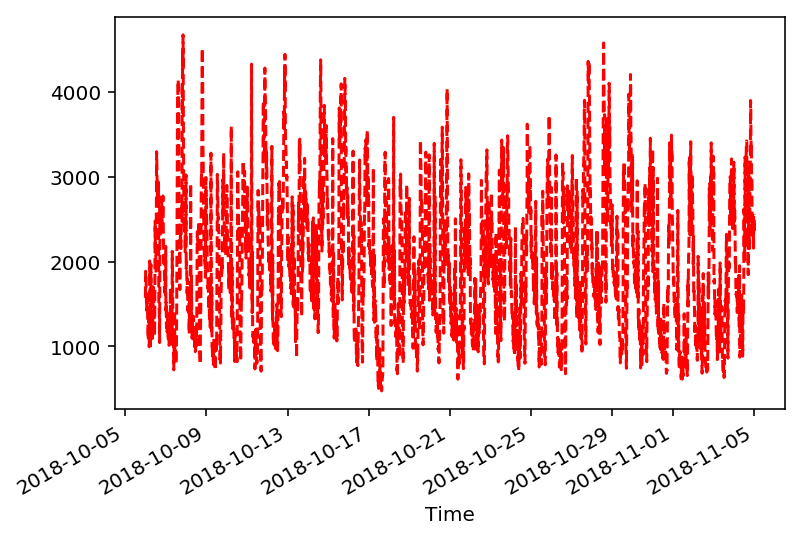

In [21]:
fit4.fittedvalues.plot(style='--', color='red')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


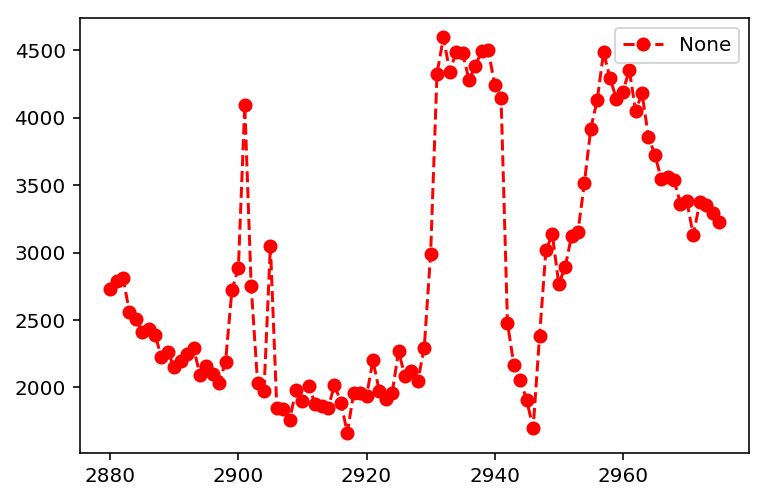

In [22]:
forecast=fit4.forecast(96)
forecast.plot(style='--', marker='o', color='red', legend=True)

In [23]:
compare=clean('Energy_Balance_'+predict_date)
compare

,Consumption
Time,
2018-11-05 00:15:00,3420
2018-11-05 00:30:00,2029
2018-11-05 00:45:00,2904
2018-11-05 01:00:00,1903
2018-11-05 01:15:00,2525
2018-11-05 01:30:00,1702
2018-11-05 01:45:00,1629
2018-11-05 02:00:00,2084
2018-11-05 02:15:00,1703


In [24]:
pmb=predict_month-1
if predict_day>1:
        db=(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(31).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(30).zfill(2))
    else:
        if predict_year%4==0:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(29).zfill(2))
        else:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(38).zfill(2))    
dayb=clean('Energy_Balance_'+db)
bf=clean('Energy_Balance_'+str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
for i in range(compare.shape[0]):
    if compare.iloc[i,0]==0:
        compare.iloc[i,0]=dayb.iloc[i,0]

In [25]:
forecastcolumn=[]
for i in range(96):
    forecastcolumn.append(forecast.iloc[i])

In [26]:
compare['Forecast']=forecastcolumn

In [27]:
compare.rename(columns={'Consumption':'Real'},inplace=True)

In [28]:
compare

,Real,Forecast
Time,,
2018-11-05 00:15:00,3420,2731.195160
2018-11-05 00:30:00,2029,2787.922099
2018-11-05 00:45:00,2904,2813.569896
2018-11-05 01:00:00,1903,2558.464729
2018-11-05 01:15:00,2525,2507.868394
2018-11-05 01:30:00,1702,2410.415704
2018-11-05 01:45:00,1629,2433.931081
2018-11-05 02:00:00,2084,2386.091367
2018-11-05 02:15:00,1703,2226.277945


## Get missing info 13/12 9:15 =1000

In [29]:
compare['Error']=compare['Real']-compare['Forecast']

In [30]:
compare['absError/Real']=abs(compare['Error'])/compare['Real']

In [31]:
compare

,Real,Forecast,Error,absError/Real
Time,,,,
2018-11-05 00:15:00,3420,2731.195160,688.804840,0.201405
2018-11-05 00:30:00,2029,2787.922099,-758.922099,0.374038
2018-11-05 00:45:00,2904,2813.569896,90.430104,0.031140
2018-11-05 01:00:00,1903,2558.464729,-655.464729,0.344438
2018-11-05 01:15:00,2525,2507.868394,17.131606,0.006785
2018-11-05 01:30:00,1702,2410.415704,-708.415704,0.416225
2018-11-05 01:45:00,1629,2433.931081,-804.931081,0.494126
2018-11-05 02:00:00,2084,2386.091367,-302.091367,0.144957
2018-11-05 02:15:00,1703,2226.277945,-523.277945,0.307268


In [39]:
compare.sort_values('absError/Real',ascending=False)

,Real,Forecast,Error,absError/Real
Time,,,,
2018-11-05 13:00:00,828,4326.788293,-3498.788293,4.225590
2018-11-05 12:45:00,721,2988.058176,-2267.058176,3.144325
2018-11-05 08:45:00,602,1842.892746,-1240.892746,2.061284
2018-11-05 10:30:00,730,2199.140212,-1469.140212,2.012521
2018-11-05 12:30:00,785,2288.859421,-1503.859421,1.915744
2018-11-05 11:45:00,729,2082.433301,-1353.433301,1.856561
2018-11-05 09:00:00,716,2019.085279,-1303.085279,1.819952
2018-11-05 14:30:00,1571,4385.822218,-2814.822218,1.791739
2018-11-05 10:00:00,703,1955.547892,-1252.547892,1.781718


In [32]:
MAPE=compare['absError/Real'].sum()*100/96
MAPE

79.32354739389882

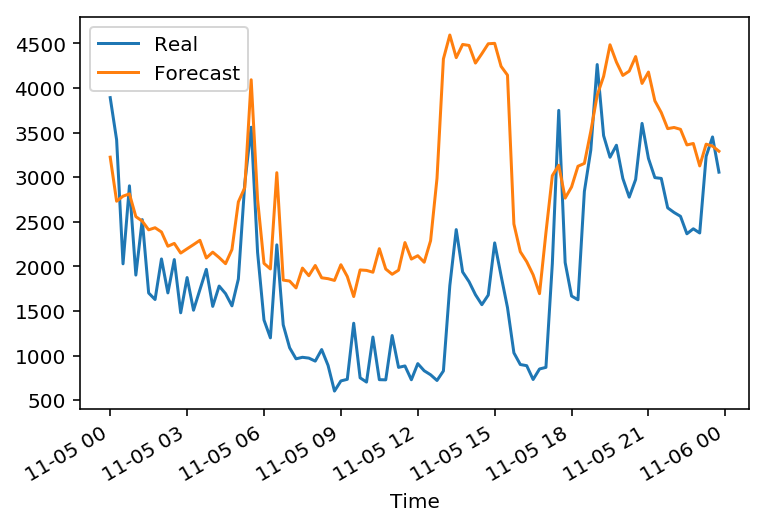

In [33]:
compare[['Real','Forecast']].plot(kind='line')

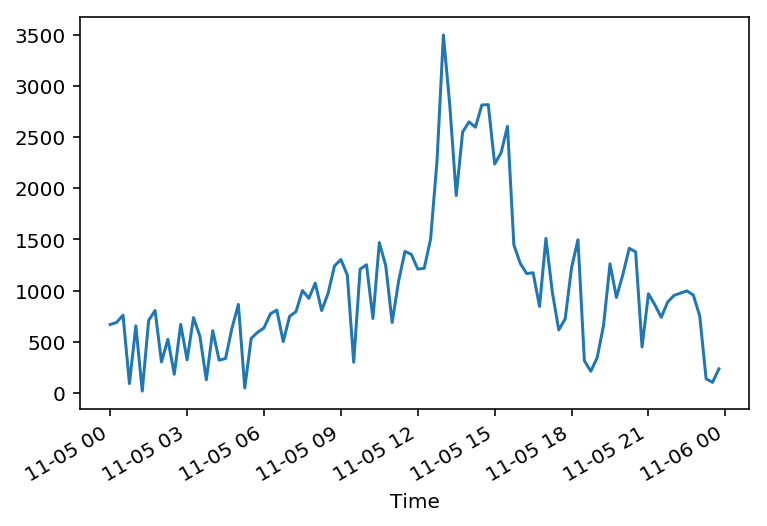

In [34]:
abs(compare.Error).plot(kind='line')

In [35]:
fit4.model.params

{'smoothing_level': 0.47535244556818973,
 'smoothing_slope': 1.7236835356699999e-18,
 'smoothing_seasonal': 3.1851092350170434e-13,
 'damping_slope': nan,
 'initial_level': 2091.700020590827,
 'initial_slope': 1.6896076618523788,
 'initial_seasons': array([0.90177328, 0.91998989, 0.92793606, 0.84333056, 0.82619267,
        0.79364608, 0.8009431 , 0.78476397, 0.73179611, 0.74191234,
        0.70588004, 0.72119011, 0.73617483, 0.75166846, 0.68620941,
        0.70727292, 0.68705638, 0.66420005, 0.71586017, 0.88987544,
        0.94154529, 1.33582737, 0.89666025, 0.66306862, 0.64242996,
        0.99356349, 0.60103275, 0.59719478, 0.57184734, 0.64379826,
        0.61574913, 0.6525921 , 0.60747044, 0.60384158, 0.59715129,
        0.65388484, 0.61078433, 0.53775744, 0.63385951, 0.63192502,
        0.62492974, 0.70986544, 0.63585841, 0.61654092, 0.63094248,
        0.73031855, 0.67036529, 0.68217934, 0.65824776, 0.73561651,
        0.95981079, 1.38907785, 1.47441833, 1.39237726, 1.43891267,
   